In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [ ]:
#to do list
# feature meanings
# autoencoder clustering
# clustering plots
# why cluster with SdA?

In [2]:
# import data
y_all = pd.read_csv('fraudlabels.csv',names=["fraud"])
# feature names and data are in different csv files
with open(r"attributes.csv","r", encoding='utf8') as f:
    cr = csv.reader(f,delimiter=" ")
    features = list(cr)  # create a list of rows for instance
features = [x[0] for x in features]
X_all = pd.read_csv('fraudnumerics.csv',names=features)
# no type conversions required 

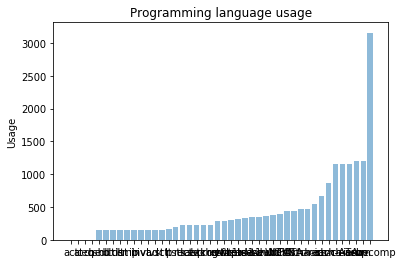

In [17]:
# bar graph for missing values in pandas dataframe
objects = features
y_pos = np.arange(len(objects))
missing = pd.DataFrame({"null":X_all.isnull().sum().sort_values()})
 
plt.bar(y_pos, missing["null"], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()


In [22]:
# count NaN values in each column
missing['missing/total']  = missing['null']/ X_all.shape[0]

print(missing.head())
# A lot of missing data
# going to delete data with more than 25% data missing
# get columns that fit into this category 
# don'tknow the meaning of the features - if given I could make more educated guesses about which columns can be dropped
drop_rate = 0.25
to_drop = missing.index[missing['missing/total'] > drop_rate].tolist()
# check all columns' data types
print(X_all.dtypes.head())
# all column types are numeric

#What is the spread of missing numbers

           null  missing/total
new-comp      0       0.000000
lease-dum     0       0.000000
oplease       0       0.000000
exchg         0       0.000000
at          144       0.045613
act     float64
at      float64
ceq     float64
che     float64
csho    float64
dtype: object


In [23]:
print("X shape: ", X_all.shape)
print("y shape: ",y_all.shape)

#dropping columns with more than 25% of data missing until I find out column labels
X_all = X_all.drop(columns=to_drop)
print("X shape: ", X_all.shape)


X shape:  (3157, 44)
y shape:  (3157, 1)
X shape:  (3157, 37)


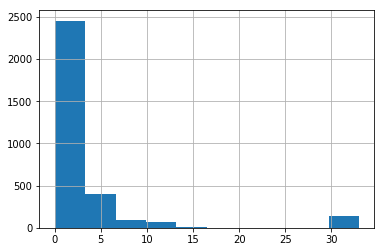

In [35]:
#look at rows with missing data 
X_all.isnull().sum(axis=1).hist()
temp_X = pd.DataFrame({"rownull":X_all.isnull().sum(axis=1)})
#there is a group of ~ 100 row missing 29 or more values
# get index of these rows and drop 
drop_rate_row = 29
# returns which rows to drop in both X and Y dataframe
to_drop = temp_X.index[temp_X['rownull'] > drop_rate_row].tolist()

In [38]:
#how many rows are going to be dropped?
print(len(to_drop))
#axis = 0, dropping rows
X_all = X_all.drop(to_drop,axis=0)
y_all = y_all.drop(to_drop,axis=0)


144


X shape:  (3013, 37)
y shape:  (3013, 1)


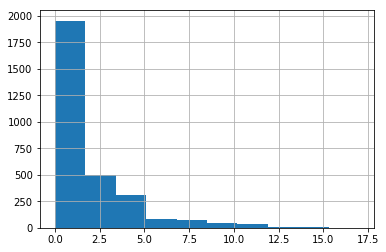

In [41]:
print("X shape: ", X_all.shape)
print("y shape: ",y_all.shape)
X_all.isnull().sum(axis=1).hist()

# IF ROWS BEING DROPPED ARE MOSTLY FRAUDULENT THIS MIGHT BE IMPORTANT need to look into this laters
# now rows are missing at most 15 features out of 37

In [44]:
#Imputing missing values with mean from column
X_all = X_all.fillna(X_all.mean())

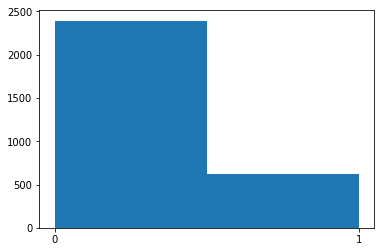

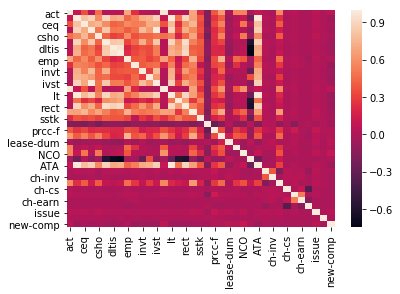

In [48]:
#print(X_all.describe())
# need to add titles to histograms
y = [y_all.fraud.sum(), y_all[y_all.fraud == 0].shape[0]]
plt.hist(y_all, bins=2)
plt.show()
sns.heatmap(X_all.corr())

In [51]:
# do i need to scale data after split .... do i need to split while clustering....
# need to scale the data 
# explain why i chose to use robust scaler (outliers, maybe show graph with outliers before and after)
# find which features have outliers
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
transformer = RobustScaler().fit(X_all.values)
X_sc = transformer.transform(X_all.values)

In [ ]:
#http://www.iro.umontreal.ca/~pift6266/H10/notes/SdA.html